### Cleaning Indeed Reviews Data

The goal from this dataset is to figure out:
- How different industries affect the work quality
- How different ranks affect the work quality
- How different occupations affect the work quality

### Basic Imports

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

In [61]:
review_data = pd.read_excel('Datasets/webscraping_indeed_unique_reviews_24112020.xlsx');

review_data.head(3)

,_OccupationRole,_Rank,Author,Company,Date,Employment,Occupation,Place,Review Raw,Review Removed Punctuation,Review Stopwords Removed,ReviewStopwordsRemoved2,Table Name,Rating
0,Sales,NaN,Retail Assistant (Former Employee) - City Hall...,Charles-&-Keith,2019-11-23,Former Employee,Retail Assistant,City Hall,Eazy cash for student who want to earn extra p...,Eazy cash for student who want to earn extra p...,"['eazy', 'cash', 'student', 'want', 'earn', 'e...",eazy cash student want earn extra pocket money...,webscraping_indeed_reviews_Charles-&-Keith2411...,3
1,NaN,NaN,Fashion Advisor (Former Employee) - Jurong poi...,Charles-&-Keith,2020-07-07,Former Employee,Fashion Advisor,Jurong point,Working in Charles and Keith is definitely a g...,Working in Charles and Keith is definitely a g...,"['working', 'charles', 'keith', 'definitely', ...",working charles keith definitely good opportun...,webscraping_indeed_reviews_Charles-&-Keith2411...,5
2,NaN,Manager,Boutique Manager (Current Employee) - Singapor...,Charles-&-Keith,2020-04-01,Current Employee,Boutique Manager,Singapore,Charles and Keith is a well known local brand ...,Charles and Keith is a well known local brand ...,"['charles', 'keith', 'well', 'known', 'local',...",charles keith well known local brand singapore...,webscraping_indeed_reviews_Charles-&-Keith2411...,3


---

We have the following features

ReviewStopwordsRemoved:
  - This can help us figure out type of benefits
  
Rank:
  - Position of the person

Occupation:
  - What jobs they do. This can help us get the industry
 
OccupationRole:
  - Effectively just what department they work at (e.g. a Lawyer in OCBC will still fall under law occupation Role)


---

In [62]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3315 entries, 0 to 3314
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   _OccupationRole             1870 non-null   object        
 1   _Rank                       956 non-null    object        
 2   Author                      3315 non-null   object        
 3   Company                     3315 non-null   object        
 4   Date                        3315 non-null   datetime64[ns]
 5   Employment                  3315 non-null   object        
 6   Occupation                  3305 non-null   object        
 7   Place                       3312 non-null   object        
 8   Review Raw                  3314 non-null   object        
 9   Review Removed Punctuation  3315 non-null   object        
 10  Review Stopwords Removed    3149 non-null   object        
 11  ReviewStopwordsRemoved2     3066 non-null   object      

In [63]:
# Dropping rows and columns
review_data.drop(columns=['Table Name'] , inplace=True)
review_data.dropna(subset=['Occupation'] , inplace=True)

### Industry and Occupation

In [64]:
print(review_data['Company'].unique())
print(review_data['_OccupationRole'].unique())
print(review_data['Occupation'].unique())
review_data[['Occupation' , 'Company']]

## There are only 10 unique companies, i can just manually label each based on their industry
## There is alot of occupation 

['Charles-&-Keith' 'Dbs-Bank' 'Giordano' 'Isetann-Department-Store'
 'M1-Limited' 'Ocbc-Bank' 'Singtel' 'Uniqlo' 'United-Overseas-Bank'
 'Starhub']
['Sales' nan 'Customer Service' 'Product' 'Marketing' 'Technician'
 'Analysts' 'Business Development' 'Administration' 'Engineering'
 'Finance/Accounts' 'Project Management']
['Retail Assistant' 'Fashion Advisor' 'Boutique Manager' ...
 'Part Time Bank Teller' 'contract staff' 'Senior Loans Manager']


,Occupation,Company
0,Retail Assistant,Charles-&-Keith
1,Fashion Advisor,Charles-&-Keith
2,Boutique Manager,Charles-&-Keith
3,Retail Assistant,Charles-&-Keith
4,Sales Associate,Charles-&-Keith
...,...,...
3310,Senior officer,United-Overseas-Bank
3311,Supervisor,United-Overseas-Bank
3312,Associate Officer,United-Overseas-Bank
3313,contract staff,United-Overseas-Bank


In [65]:
## handling industry (easy)
company_to_industry_map = {
  'Charles-&-Keith': 'Fashion Retail',
  'Dbs-Bank': 'Banking & Finance',
  'Giordano': 'Apparel Retail',
  'Isetann-Department-Store': 'General Retail',
  'M1-Limited': 'Telecommunications',
  'Ocbc-Bank': 'Banking & Finance',
  'Singtel': 'Telecommunications',
  'Uniqlo': 'Fashion Retail',
  'United-Overseas-Bank': 'Banking & Finance',
  'Starhub': 'Telecommunications',
}

def createIndustry(company_name):
  global company_to_industry_map
  return company_to_industry_map[company_name]


review_data['Industry'] = review_data['Company'].apply(createIndustry)

review_data['Industry']

0          Fashion Retail
1          Fashion Retail
2          Fashion Retail
3          Fashion Retail
4          Fashion Retail
              ...        
3310    Banking & Finance
3311    Banking & Finance
3312    Banking & Finance
3313    Banking & Finance
3314    Banking & Finance
Name: Industry, Length: 3305, dtype: object

In [66]:
# Using LDA to extract the occupation departments
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# vectorising the occupations
vectoriser = CountVectorizer(stop_words="english")
data_matrix = vectoriser.fit_transform(review_data['Occupation'].values.flatten())
features = vectoriser.get_feature_names_out()

In [67]:
def displayTopicsKeywords(components):
  for index , topic in enumerate(components):
    features_index = topic.argsort()[::-1][:5]
    likely_features = [features[i] for i in features_index]
    print(f"Topic {index + 1}: {likely_features}")

In [71]:
for k in range(15, 26):
  lda= LatentDirichletAllocation(n_components= k , random_state=42)
  lda.fit(data_matrix)
  print('-----------------------------------------')
  print(f'Results for n-topics = {k}')
  displayTopicsKeywords(lda.components_)

-----------------------------------------
Results for n-topics = 15
Topic 1: ['cashier', 'executive', 'sales', 'corporate', 'secretary']
Topic 2: ['associate', 'sales', 'retail', 'assistant', 'president']
Topic 3: ['supervisor', 'manager', 'relationship', 'floor', 'telesales']
Topic 4: ['intern', 'credit', 'developer', 'risk', 'promoter']
Topic 5: ['senior', 'officer', 'team', 'lead', 'leader']
Topic 6: ['vendeuse', 'product', 'banking', 'porter', 'executive']
Topic 7: ['engineer', 'associate', 'business', 'advanced', 'sale']
Topic 8: ['manager', 'store', 'assistant', 'staff', 'planning']
Topic 9: ['customer', 'service', 'officer', 'advisor', 'executive']
Topic 10: ['director', 'specialist', 'protection', 'financial', 'mortgage']
Topic 11: ['consultant', 'personal', 'financial', 'project', 'banker']
Topic 12: ['assistant', 'analyst', 'retail', 'time', 'business']
Topic 13: ['clerk', 'representative', 'bank', 'executive', 'merchandising']
Topic 14: ['support', 'specialist', 'technical',

In [72]:
# Though a brief view of the data, i decided to take the results for n-topic  = 24
# Using the existing values of 
lda= LatentDirichletAllocation(n_components= 25 , random_state=42)
lda.fit(data_matrix)
displayTopicsKeywords(lda.components_)


Topic 1: ['cashier', 'sales', 'associate', 'person', 'レジ']
Topic 2: ['associate', 'sales', 'retail', 'advance', 'skilled']
Topic 3: ['manager', 'relationship', 'floor', 'telesales', 'treasures']
Topic 4: ['cash', 'vp', 'register', 'wrap', 'clerk']
Topic 5: ['senior', 'officer', 'engineer', 'systems', 'technician']
Topic 6: ['manager', 'vendeuse', 'product', 'porter', 'prêt']
Topic 7: ['associate', 'store', 'advanced', 'sale', 'digital']
Topic 8: ['manager', 'assistant', 'store', 'planning', 'wealth']
Topic 9: ['customer', 'service', 'officer', 'care', 'operation']
Topic 10: ['developer', 'director', 'specialist', 'mortgage', 'alterations']
Topic 11: ['assistant', 'sales', 'marketing', 'content', 'superviseur']
Topic 12: ['retail', 'assistant', 'stock', 'overnight', 'associates']
Topic 13: ['clerk', 'accounts', 'merchandising', 'office', 'admin']
Topic 14: ['engineer', 'support', 'lead', 'technical', 'software']
Topic 15: ['supervisor', 'operations', 'division', 'advisor', 'technology']

In [77]:

# I will be using the existing values from occupationRoles
# They will be used as referrence to label my topics
# Through comparing the result from n=25, we can generate a map as follows:
topic_to_department_map = {
    1: 'Sales',                    
    2: 'Sales',                    
    3: 'Sales',                    
    4: 'Administration',           
    5: 'Engineering',              
    6: 'Product',                  
    7: 'Sales',                    
    8: 'Project Management',       
    9: 'Customer Service',         
    10: 'Engineering',             
    11: 'Marketing',               
    12: 'Sales',                   
    13: 'Administration',          
    14: 'Engineering',             
    15: 'Project Management',      
    16: 'Sales',                   
    17: 'Customer Service',        
    18: 'Finance/Accounts',        
    19: 'Project Management',      
    20: 'Finance/Accounts',        
    21: 'Sales',                   
    22: 'Administration',          
    23: 'Analysts',                
    24: 'Engineering',             
    25: 'Technician'               
}

topic_weigths = lda.transform(data_matrix)
topic_weigths = np.argmax(topic_weigths , axis=1) + 1 # get the max weight index in each row 
def createOccupationRole(row):
  global topic_to_department_map

  if pd.notna(row['_OccupationRole']):
    return row['_OccupationRole']
  else:
    role = topic_to_department_map[row['topic']]
    return role
   
review_data['topic'] = topic_weigths
review_data['_OccupationRole'] = review_data.apply(createOccupationRole , axis=1)


In [78]:
review_data['_OccupationRole']

0                    Sales
1         Finance/Accounts
2         Finance/Accounts
3                    Sales
4                    Sales
               ...        
3310           Engineering
3311    Project Management
3312                 Sales
3313                 Sales
3314           Engineering
Name: _OccupationRole, Length: 3305, dtype: object

### Extracting Benefits

### Plottings

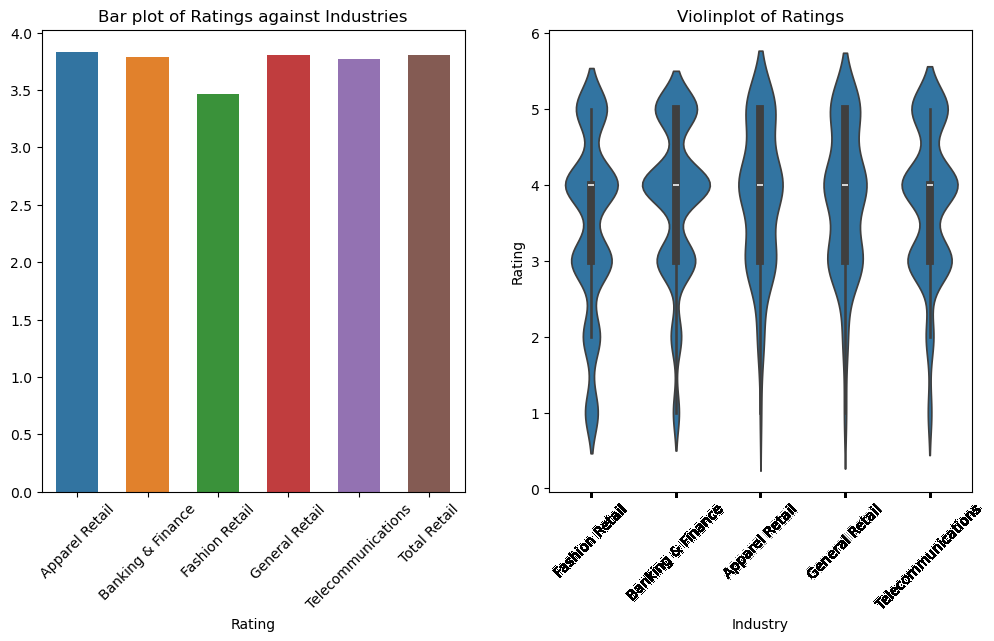

,Rating
Industry,
Apparel Retail,3.833333
Banking & Finance,3.786444
Fashion Retail,3.468193
General Retail,3.805556
Telecommunications,3.771552
Total Retail,3.805556


In [22]:
grouped_by_industry = review_data[['Industry' , 'Rating']].groupby(by='Industry').mean()

# I also want to 'group' the retails tgt
mean_retail_rating = grouped_by_industry.loc[['General Retail' , 'Apparel Retail' ,'Fashion Retail'] , :].median()

# adding to the df
grouped_by_industry.loc['Total Retail'] = mean_retail_rating

# Plottings
X = grouped_by_industry.index
y = grouped_by_industry['Rating'].values

fig , axes = plt.subplots(1 , 2 ,figsize=(12 , 6))

# Bar plot
sns.barplot(x=X , y=y , hue=X , width=0.6 , ax=axes[0])
axes[0].set_xticks(ticks=X , labels=X , rotation=45)
axes[0].set_xlabel('Rating')
axes[0].set_title('Bar plot of Ratings against Industries')


# Box plot
X = review_data['Industry']
sns.violinplot(x=X , y=review_data['Rating'] , ax=axes[1])
axes[1].set_xticks(ticks=X, labels=X , rotation=45)
axes[1].set_title('Violinplot of Ratings')

plt.show()

grouped_by_industry